# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import yaml
import warnings

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, f1_score, accuracy_score

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
#warnings.filterwarnings("ignore")

# Lecture du fichier data_cleaned_final_sans_dummies.csv

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

In [4]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'grav', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df[cat] = df[cat].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  int32  
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int32  
 6   int             447136 non-null  int32  
 7   atm             447136 non-null  int32  
 8   col             447136 non-null  int32  
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int32  
 12  circ            447136 non-null  int32  
 13  prof            447136 non-null  int32  
 14  plan            447136 non-null  int32  
 15  surf            447136 non-null  int32  
 16  infra           447136 non-null  int32  
 17  situ           

# Regroupement de modalités de 'grav' en 2 modalités : "tues" et "autres" 

In [5]:
# "indemnes (1) + tués (2) + blessés légers (4)" => 0
df['grav'] = df['grav'].replace([1, 2, 4], 0)

# "blessés hospitalisés (3)" => 1
df['grav'] = df['grav'].replace([3], 1)

df['grav'].unique()

array([0, 1])

# Séparation en train et test

Suppression des colonnes qui ne serviront pas pour la modélisation

In [6]:
df = df.drop(['an', 'jour', 'grav_rec', 'date', 'dep'], axis = 1)

Séparation des données de la cible

In [7]:
X = df.drop('grav', axis = 1)
y = df['grav']

y.value_counts(normalize = True)

grav
0    0.84345
1    0.15655
Name: proportion, dtype: float64

Séparation en train et test en gardant la même porportion de chque modalité de la cible dans les jeux d'entraînement et de test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

grav
0    0.843451
1    0.156549
Name: proportion, dtype: float64
grav
0    0.843448
1    0.156552
Name: proportion, dtype: float64


In [9]:
X_train.shape

(335352, 35)

# Création de train et test avec Oversampling et Undersampling

### Oversampling

Avec SMOTENC

In [10]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
smo = SMOTENC(categorical_features = cat)
X_train_sm, y_train_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_train_sm).value_counts()))

Classes échantillon SMOTE : {0: 282853, 1: 282853}


Avec RandomOverSampler

In [11]:
rOs = RandomOverSampler()
X_train_ro, y_train_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_train_ro).value_counts()))

Classes échantillon oversampled : {0: 282853, 1: 282853}


### Undersampling

Avec RandomUnderSampler

In [12]:
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_train_ru).value_counts()))

Classes échantillon undersampled : {0: 52499, 1: 52499}


Avec ClusterCentroids

In [13]:
cc = ClusterCentroids()
X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon CC :', dict(pd.Series(y_train_cc).value_counts()))

Classes échantillon CC : {0: 52499, 1: 52499}


# Decision Tree

### Selection des variables

In [106]:
dt = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

In [107]:
print("Train acuracy :", np.round(dt.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(dt.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = dt.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.96 %
Test acuracy :  80.09 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,82598,11686
1,10566,6934



Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      0.88      0.88     94284
           1       0.37      0.40      0.38     17500

    accuracy                           0.80    111784
   macro avg       0.63      0.64      0.63    111784
weighted avg       0.81      0.80      0.80    111784



Calcul de l'importance de chaque variable

In [108]:
importances_dt = pd.DataFrame({'feature':X_train.columns,'importance':np.round(dt.feature_importances_,3)})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(38)

,importance
feature,
lat,0.178
long,0.145
age_usager,0.119
heure,0.072
mois,0.058
eq_ceinture,0.052
col,0.034
obs,0.024
catr,0.023


In [109]:
importances_dt.shape

(35, 1)

Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [110]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_dt), 1):
    liste_var = importances_dt.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    dt_2 = DecisionTreeClassifier(random_state = 42).fit(X_train_2, y_train)

    score = dt_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_dt = pd.DataFrame(dico)
y_pred_tableau_dt = y_pred_tableau_dt.sort_values(by = 'scores', ascending = False)
y_pred_tableau_dt.head(5)

,nombre_variable,scores
26,27,0.801796
21,22,0.801769
27,28,0.801761
24,25,0.801617
19,20,0.801564


In [111]:
nb_variable_dt = y_pred_tableau_dt.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_dt, 'variables')

La meilleur accuracy est obtenue avec 27.0 variables


In [112]:
meilleurs_variables_dt = importances_dt.index[0 : int(nb_variable_dt)]
meilleurs_variables_dt

Index(['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture', 'col',
       'obs', 'catr', 'place_rec', 'eq_indetermine', 'situ', 'manv', 'agg',
       'infra', 'lum', 'sexe', 'motor', 'catv', 'circ', 'weekend', 'obsm',
       'surf', 'plan', 'prof', 'int', 'jour_chome'],
      dtype='object', name='feature')

In [113]:
liste_var = importances_dt.index[0 : int(nb_variable_dt)]
X_train_dt = X_train[liste_var]
X_test_dt = X_test[liste_var]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_dt, y_train)

In [114]:
print("Train acuracy :", np.round(dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.95 %
Test acuracy :  80.18 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,82656,11628
1,10528,6972



Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      0.88      0.88     94284
           1       0.37      0.40      0.39     17500

    accuracy                           0.80    111784
   macro avg       0.63      0.64      0.63    111784
weighted avg       0.81      0.80      0.80    111784



### Hyperparamétrage

In [29]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture', 'col',
       'obs', 'catr', 'place_rec', 'eq_indetermine', 'situ', 'manv', 'agg',
       'infra', 'lum', 'sexe', 'motor', 'catv', 'circ', 'weekend', 'obsm',
       'surf', 'plan', 'prof', 'int', 'jour_chome']
X_train_dt = X_train[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_dt, y_train)

##### Avec class_weight = None

In [116]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [117]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.846156
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.844996
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.847274
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.846916
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.847274
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.847000
140  {'class_weight': None, 'criterion': 'entropy',...         0.845276
141  {'class_weight': None, 'criterion': 'entropy',...         0.847000
142  {'class_weight': None, 'criterion': 'entropy',...         0.845276
143  {'class_weight': None, 'criterion': 'entropy',...         0.847000

[144 rows x 2 columns]


In [118]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
0.8476615574046018


In [119]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 85.07 %
Test acuracy :  84.8 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,92012,2272
1,14716,2784



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.98      0.92     94284
           1       0.55      0.16      0.25     17500

    accuracy                           0.85    111784
   macro avg       0.71      0.57      0.58    111784
weighted avg       0.81      0.85      0.81    111784



Recherche du meilleur max_depth

In [30]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['random'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [31]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
0.5798471184614635


In [32]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.1 %
Test acuracy :  84.77 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,91656,2628
1,14395,3105



Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.97      0.92     94284
           1       0.54      0.18      0.27     17500

    accuracy                           0.85    111784
   macro avg       0.70      0.57      0.59    111784
weighted avg       0.81      0.85      0.81    111784



##### Avec class_weight = 'balanced'

In [120]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced'],
            }

In [121]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': 'balanced', 'criterion': 'gin...         0.725086
1    {'class_weight': 'balanced', 'criterion': 'gin...         0.678410
2    {'class_weight': 'balanced', 'criterion': 'gin...         0.716692
3    {'class_weight': 'balanced', 'criterion': 'gin...         0.662990
4    {'class_weight': 'balanced', 'criterion': 'gin...         0.711688
..                                                 ...              ...
139  {'class_weight': 'balanced', 'criterion': 'ent...         0.689982
140  {'class_weight': 'balanced', 'criterion': 'ent...         0.718731
141  {'class_weight': 'balanced', 'criterion': 'ent...         0.689982
142  {'class_weight': 'balanced', 'criterion': 'ent...         0.718731
143  {'class_weight': 'balanced', 'criterion': 'ent...         0.689982

[144 rows x 2 columns]


In [122]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.8048140502876148


In [123]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.95 %
Test acuracy :  80.48 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,83783,10501
1,11316,6184



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     94284
           1       0.37      0.35      0.36     17500

    accuracy                           0.80    111784
   macro avg       0.63      0.62      0.62    111784
weighted avg       0.80      0.80      0.80    111784



Recherche du meilleur max_depth

In [95]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best', 'random'],
            'max_depth' : [18, 20, 22, 24, 26],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced'],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [96]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.647794918188767


In [97]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.69 %
Test acuracy :  76.66 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,74810,19474
1,6615,10885



Rapport de classification :
               precision    recall  f1-score   support

           0       0.92      0.79      0.85     94284
           1       0.36      0.62      0.45     17500

    accuracy                           0.77    111784
   macro avg       0.64      0.71      0.65    111784
weighted avg       0.83      0.77      0.79    111784



##### Recherche du meilleur class_weight

In [101]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : [None],
            'random_state' : [42],
            'class_weight' : [{0:1, 1:3}]
            }

In [102]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': {0: 1, 1: 3}, 'criterion': 'g...         0.784197
1    {'class_weight': {0: 1, 1: 3}, 'criterion': 'g...         0.783261
2    {'class_weight': {0: 1, 1: 3}, 'criterion': 'g...         0.784084
3    {'class_weight': {0: 1, 1: 3}, 'criterion': 'g...         0.787623
4    {'class_weight': {0: 1, 1: 3}, 'criterion': 'g...         0.783946
..                                                 ...              ...
139  {'class_weight': {0: 1, 1: 3}, 'criterion': 'e...         0.784021
140  {'class_weight': {0: 1, 1: 3}, 'criterion': 'e...         0.786770
141  {'class_weight': {0: 1, 1: 3}, 'criterion': 'e...         0.784021
142  {'class_weight': {0: 1, 1: 3}, 'criterion': 'e...         0.786770
143  {'class_weight': {0: 1, 1: 3}, 'criterion': 'e...         0.784021

[144 rows x 2 columns]


In [103]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.8033618459640908


In [104]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.95 %
Test acuracy :  80.57 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,83274,11010
1,10706,6794



Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      0.88      0.88     94284
           1       0.38      0.39      0.38     17500

    accuracy                           0.81    111784
   macro avg       0.63      0.64      0.63    111784
weighted avg       0.81      0.81      0.81    111784



Sélection du meilleur max_depth

In [108]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [8, 10, 12, 14, 16, 18, 20],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : [None],
            'random_state' : [42],
            'class_weight' : [{0:1, 1:3}]
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [109]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.68204616753799


In [110]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 80.81 %
Test acuracy :  78.85 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,76232,18052
1,5588,11912



Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.81      0.87     94284
           1       0.40      0.68      0.50     17500

    accuracy                           0.79    111784
   macro avg       0.66      0.74      0.68    111784
weighted avg       0.85      0.79      0.81    111784



##### Avec SMOTE

In [39]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture', 'col',
       'obs', 'catr', 'place_rec', 'eq_indetermine', 'situ', 'manv', 'agg',
       'infra', 'lum', 'sexe', 'motor', 'catv', 'circ', 'weekend', 'obsm',
       'surf', 'plan', 'prof', 'int', 'jour_chome']
X_train_sm_dt = X_train_sm[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_sm_dt, y_train_sm)

In [129]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [130]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_sm_dt, y_train_sm)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.779509
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.730067
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.781028
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.737374
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.783165
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.766764
140  {'class_weight': None, 'criterion': 'entropy',...         0.803016
141  {'class_weight': None, 'criterion': 'entropy',...         0.766764
142  {'class_weight': None, 'criterion': 'entropy',...         0.803016
143  {'class_weight': None, 'criterion': 'entropy',...         0.766764

[144 rows x 2 columns]


In [131]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.8138946549010992


In [132]:
print("Train acuracy :", np.round(grid_dt.score(X_train_sm_dt, y_train_sm) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 89.17 %
Test acuracy :  76.1 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,74106,20178
1,6535,10965



Rapport de classification :
               precision    recall  f1-score   support

           0       0.92      0.79      0.85     94284
           1       0.35      0.63      0.45     17500

    accuracy                           0.76    111784
   macro avg       0.64      0.71      0.65    111784
weighted avg       0.83      0.76      0.79    111784



Sélection du meilleur max_depth

In [111]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_sm_dt, y_train_sm)

In [112]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.8152497375126833


In [113]:
y_train_pred = grid_dt_2.predict(X_train_sm_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_sm, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 93.51 %
Test acuracy :  76.44 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,75134,19150
1,7184,10316



Rapport de classification :
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     94284
           1       0.35      0.59      0.44     17500

    accuracy                           0.76    111784
   macro avg       0.63      0.69      0.65    111784
weighted avg       0.82      0.76      0.79    111784



##### Avec RandomOverSampler

In [43]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture', 'col',
       'obs', 'catr', 'place_rec', 'eq_indetermine', 'situ', 'manv', 'agg',
       'infra', 'lum', 'sexe', 'motor', 'catv', 'circ', 'weekend', 'obsm',
       'surf', 'plan', 'prof', 'int', 'jour_chome']
X_train_ro_dt = X_train_ro[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_ro_dt, y_train_ro)

In [134]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [135]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_ro_dt, y_train_ro)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.750950
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.718446
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.752030
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.722043
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.749760
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.744120
140  {'class_weight': None, 'criterion': 'entropy',...         0.781917
141  {'class_weight': None, 'criterion': 'entropy',...         0.744120
142  {'class_weight': None, 'criterion': 'entropy',...         0.781917
143  {'class_weight': None, 'criterion': 'entropy',...         0.744120

[144 rows x 2 columns]


In [136]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.9326151804935275


In [137]:
print("Train acuracy :", np.round(grid_dt.score(X_train_ro_dt, y_train_ro) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.97 %
Test acuracy :  80.3 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,83597,10687
1,11334,6166



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     94284
           1       0.37      0.35      0.36     17500

    accuracy                           0.80    111784
   macro avg       0.62      0.62      0.62    111784
weighted avg       0.80      0.80      0.80    111784



Sélection du meilleur max_depth

In [44]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [10, 20, 30, 40, 50, 60, 70],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_ro_dt, y_train_ro)

In [45]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.9330799044187135


In [46]:
y_train_pred = grid_dt_2.predict(X_train_ro_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_ro, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.97 %
Test acuracy :  80.44 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,83573,10711
1,11151,6349



Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     94284
           1       0.37      0.36      0.37     17500

    accuracy                           0.80    111784
   macro avg       0.63      0.62      0.63    111784
weighted avg       0.80      0.80      0.80    111784



##### Avec RandomUnderSampler

In [47]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture', 'col',
       'obs', 'catr', 'place_rec', 'eq_indetermine', 'situ', 'manv', 'agg',
       'infra', 'lum', 'sexe', 'motor', 'catv', 'circ', 'weekend', 'obsm',
       'surf', 'plan', 'prof', 'int', 'jour_chome']
X_train_ru_dt = X_train_ru[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_ru_dt, y_train_ru)

In [139]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [140]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_ru_dt, y_train_ru)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.741138
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.705089
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.740709
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.707118
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.741214
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.718880
140  {'class_weight': None, 'criterion': 'entropy',...         0.743490
141  {'class_weight': None, 'criterion': 'entropy',...         0.718880
142  {'class_weight': None, 'criterion': 'entropy',...         0.743490
143  {'class_weight': None, 'criterion': 'entropy',...         0.718880

[144 rows x 2 columns]


In [141]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7438237262998919


In [142]:
print("Train acuracy :", np.round(grid_dt.score(X_train_ru_dt, y_train_ru) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 75.7 %
Test acuracy :  71.37 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,65693,28591
1,3415,14085



Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.70      0.80     94284
           1       0.33      0.80      0.47     17500

    accuracy                           0.71    111784
   macro avg       0.64      0.75      0.64    111784
weighted avg       0.85      0.71      0.75    111784



Recherche du meilleur max_depth

In [48]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [2, 4, 6, 8, 10, 12],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_ru_dt, y_train_ru)

In [49]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7442832647193488


In [50]:
y_train_pred = grid_dt_2.predict(X_train_ru_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_ru, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 75.79 %
Test acuracy :  71.52 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,66014,28270
1,3570,13930



Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.70      0.81     94284
           1       0.33      0.80      0.47     17500

    accuracy                           0.72    111784
   macro avg       0.64      0.75      0.64    111784
weighted avg       0.85      0.72      0.75    111784



##### Avec ClusterCentroids

In [51]:
liste_var_dt = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture', 'col',
       'obs', 'catr', 'place_rec', 'eq_indetermine', 'situ', 'manv', 'agg',
       'infra', 'lum', 'sexe', 'motor', 'catv', 'circ', 'weekend', 'obsm',
       'surf', 'plan', 'prof', 'int', 'jour_chome']
X_train_cc_dt = X_train_cc[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_cc_dt, y_train_cc)

In [144]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [145]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_cc_dt, y_train_cc)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.811682
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.805453
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.812815
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.800453
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.811348
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.824606
140  {'class_weight': None, 'criterion': 'entropy',...         0.839006
141  {'class_weight': None, 'criterion': 'entropy',...         0.824606
142  {'class_weight': None, 'criterion': 'entropy',...         0.839006
143  {'class_weight': None, 'criterion': 'entropy',...         0.824606

[144 rows x 2 columns]


In [146]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.8390059472219766


In [147]:
print("Train acuracy :", np.round(grid_dt.score(X_train_cc_dt, y_train_cc) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 85.88 %
Test acuracy :  39.41 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,28878,65406
1,2323,15177



Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.31      0.46     94284
           1       0.19      0.87      0.31     17500

    accuracy                           0.39    111784
   macro avg       0.56      0.59      0.38    111784
weighted avg       0.81      0.39      0.44    111784



Recherche du meilleur max_depth

In [52]:
params_dt = {'criterion' : ['entropy'],
            'splitter' : ['best'],
            'max_depth' : [10, 20, 30, 40, 50, 60, 70],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_cc_dt, y_train_cc)

In [53]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.8344152175637456


In [54]:
y_train_pred = grid_dt_2.predict(X_train_cc_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_cc, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.42 %
Test acuracy :  39.31 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,28980,65304
1,2537,14963



Rapport de classification :
               precision    recall  f1-score   support

           0       0.92      0.31      0.46     94284
           1       0.19      0.86      0.31     17500

    accuracy                           0.39    111784
   macro avg       0.55      0.58      0.38    111784
weighted avg       0.80      0.39      0.44    111784



# Random Forest

### Selection des variables

In [148]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

In [149]:
print("Train acuracy :", np.round(rf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.96 %
Test acuracy :  85.22 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,90929,3355
1,13163,4337



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.96      0.92     94284
           1       0.56      0.25      0.34     17500

    accuracy                           0.85    111784
   macro avg       0.72      0.61      0.63    111784
weighted avg       0.83      0.85      0.83    111784



In [150]:
importances_rf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(38)

,importance
feature,
lat,0.133
long,0.124
age_usager,0.113
heure,0.076
mois,0.063
col,0.041
catr,0.032
eq_ceinture,0.030
place_rec,0.027


Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [151]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_rf), 1):
    liste_var = importances_rf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    rf_2 = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = rf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_rf = pd.DataFrame(dico)
y_pred_tableau_rf = y_pred_tableau_rf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_rf.head(5)

,nombre_variable,scores
32,33,0.853181
31,32,0.852564
33,34,0.852465
26,27,0.852457
29,30,0.852054


In [152]:
nb_variable_rf = y_pred_tableau_rf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_rf, 'variables')

La meilleur accuracy est obtenue avec 33.0 variables


In [153]:
meilleurs_variables_rf = importances_rf.index[0 : int(nb_variable_rf)]
meilleurs_variables_rf

Index(['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'catr',
       'eq_ceinture', 'place_rec', 'obsm', 'lum', 'manv', 'agg', 'catv',
       'situ', 'motor', 'infra', 'sexe', 'circ', 'weekend', 'eq_casque',
       'jour_chome', 'obs', 'surf', 'prof', 'plan', 'eq_indetermine', 'int',
       'atm', 'prox_pt_choc', 'eq_gants', 'eq_autre', 'eq_airbag'],
      dtype='object', name='feature')

In [154]:
liste_var = importances_rf.index[0 : int(nb_variable_rf)]
X_train_rf = X_train[liste_var]
X_test_rf = X_test[liste_var]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

In [155]:
print("Train acuracy :", np.round(rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.95 %
Test acuracy :  85.32 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,90934,3350
1,13062,4438



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.96      0.92     94284
           1       0.57      0.25      0.35     17500

    accuracy                           0.85    111784
   macro avg       0.72      0.61      0.63    111784
weighted avg       0.83      0.85      0.83    111784



### Hyperparamétrage

In [10]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'catr',
       'eq_ceinture', 'place_rec', 'obsm', 'lum', 'manv', 'agg', 'catv',
       'situ', 'motor', 'infra', 'sexe', 'circ', 'weekend', 'eq_casque',
       'jour_chome', 'obs', 'surf', 'prof', 'plan', 'eq_indetermine', 'int',
       'atm', 'prox_pt_choc', 'eq_gants', 'eq_autre', 'eq_airbag']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

##### Avec class_weight = None

In [157]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

In [158]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.850169
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.850035
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.850089
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.849984
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.849984
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.853470
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.853470
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.852814
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.852814
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.852814

[108 rows x 2 columns]


In [159]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8544096923191112


In [160]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 91.12 %
Test acuracy :  85.49 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,91661,2623
1,13602,3898



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     94284
           1       0.60      0.22      0.32     17500

    accuracy                           0.85    111784
   macro avg       0.73      0.60      0.62    111784
weighted avg       0.83      0.85      0.83    111784



Recherche du meilleur max_depth

In [114]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['entropy'],
             'max_depth' : [12, 14, 16, 18, 20, 22, 24, 26, 28, 30],
             'min_samples_split' : [20],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [115]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.624354544623365


In [116]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 94.25 %
Test acuracy :  85.53 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,91429,2855
1,13320,4180



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     94284
           1       0.59      0.24      0.34     17500

    accuracy                           0.86    111784
   macro avg       0.73      0.60      0.63    111784
weighted avg       0.83      0.86      0.83    111784



##### Avec class_weight = 'balanced'

In [161]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20],
            'min_samples_leaf' : [1, 10, 20],
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}    

In [162]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': 'balanced...         0.746308
1    {'bootstrap': False, 'class_weight': 'balanced...         0.744969
2    {'bootstrap': False, 'class_weight': 'balanced...         0.744504
3    {'bootstrap': False, 'class_weight': 'balanced...         0.744940
4    {'bootstrap': False, 'class_weight': 'balanced...         0.744940
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': 'balanced'...         0.789854
104  {'bootstrap': True, 'class_weight': 'balanced'...         0.789854
105  {'bootstrap': True, 'class_weight': 'balanced'...         0.768148
106  {'bootstrap': True, 'class_weight': 'balanced'...         0.768148
107  {'bootstrap': True, 'class_weight': 'balanced'...         0.768148

[108 rows x 2 columns]


In [163]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8513263639891658


In [164]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.95 %
Test acuracy :  85.17 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,91385,2899
1,13675,3825



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     94284
           1       0.57      0.22      0.32     17500

    accuracy                           0.85    111784
   macro avg       0.72      0.59      0.62    111784
weighted avg       0.82      0.85      0.82    111784



Recherche du meilleur max_depth

In [120]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini'],
            'max_depth' : [10, 16, 18, 20, 22, 24, 26, 28],
            'min_samples_split' : [2],
            'min_samples_leaf' : [1],
            'bootstrap' : [True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}         

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [121]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.696754557234218


In [122]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 88.45 %
Test acuracy :  81.15 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,79531,14753
1,6315,11185



Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.84      0.88     94284
           1       0.43      0.64      0.51     17500

    accuracy                           0.81    111784
   macro avg       0.68      0.74      0.70    111784
weighted avg       0.85      0.81      0.83    111784



##### Recherche du meilleur class_weight

In [20]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{0:1, 1:3}]} 

In [21]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.812752
1    {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.813125
2    {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.812469
3    {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.812284
4    {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.812284
..                                                 ...              ...
139  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.821877
140  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.821877
141  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.818006
142  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.818006
143  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.818006

[144 rows x 2 columns]


In [22]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8515589554688521


In [23]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.95 %
Test acuracy :  85.25 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,91128,3156
1,13329,4171



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     94284
           1       0.57      0.24      0.34     17500

    accuracy                           0.85    111784
   macro avg       0.72      0.60      0.63    111784
weighted avg       0.82      0.85      0.83    111784



Recherche du meilleur max_depth

In [123]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['entropy'],
            'max_depth' : [8, 10, 12, 14, 16, 18, 20, 22],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'bootstrap' : [True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{0:1, 1:3}]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [124]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.702973532461853


In [125]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.43 %
Test acuracy :  82.24 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,81183,13101
1,6750,10750



Rapport de classification :
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     94284
           1       0.45      0.61      0.52     17500

    accuracy                           0.82    111784
   macro avg       0.69      0.74      0.71    111784
weighted avg       0.85      0.82      0.83    111784



##### Avec SMOTE

In [65]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'catr',
       'eq_ceinture', 'place_rec', 'obsm', 'lum', 'manv', 'agg', 'catv',
       'situ', 'motor', 'infra', 'sexe', 'circ', 'weekend', 'eq_casque',
       'jour_chome', 'obs', 'surf', 'prof', 'plan', 'eq_indetermine', 'int',
       'atm', 'prox_pt_choc', 'eq_gants', 'eq_autre', 'eq_airbag']
X_train_sm_rf = X_train_sm[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_sm_rf, y_train_sm)

In [170]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]} 

In [171]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_sm_rf, y_train_sm)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.801056
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.800921
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.801109
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.800755
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.800755
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.842215
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.842215
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.831648
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.831648
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.831648

[108 rows x 2 columns]


In [172]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8842333823592101


In [173]:
print("Train acuracy :", np.round(grid_rf.score(X_train_sm_rf, y_train_sm) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.98 %
Test acuracy :  82.82 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,83040,11244
1,7957,9543



Rapport de classification :
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     94284
           1       0.46      0.55      0.50     17500

    accuracy                           0.83    111784
   macro avg       0.69      0.71      0.70    111784
weighted avg       0.84      0.83      0.83    111784



Recherche du meilleur max_depth

In [66]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['entropy'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_sm_rf, y_train_sm)

In [67]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8830117434313177


In [68]:
y_train_pred = grid_rf_2.predict(X_train_sm_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_sm, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.97 %
Test acuracy :  82.78 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,83036,11248
1,8001,9499



Rapport de classification :
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     94284
           1       0.46      0.54      0.50     17500

    accuracy                           0.83    111784
   macro avg       0.68      0.71      0.70    111784
weighted avg       0.84      0.83      0.83    111784



##### Avec RandomOverSampler

In [69]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'catr',
       'eq_ceinture', 'place_rec', 'obsm', 'lum', 'manv', 'agg', 'catv',
       'situ', 'motor', 'infra', 'sexe', 'circ', 'weekend', 'eq_casque',
       'jour_chome', 'obs', 'surf', 'prof', 'plan', 'eq_indetermine', 'int',
       'atm', 'prox_pt_choc', 'eq_gants', 'eq_autre', 'eq_airbag']
X_train_ro_rf = X_train_ro[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_ro_rf, y_train_ro)

In [175]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [176]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_ro_rf, y_train_ro)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.775495
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.775235
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.775162
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.774650
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.774650
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.855432
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.855432
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.821059
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.821059
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.821059

[108 rows x 2 columns]


In [177]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9722718218171893


In [178]:
print("Train acuracy :", np.round(grid_rf.score(X_train_ro_rf, y_train_ro) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.97 %
Test acuracy :  84.97 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,90704,3580
1,13224,4276



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.96      0.92     94284
           1       0.54      0.24      0.34     17500

    accuracy                           0.85    111784
   macro avg       0.71      0.60      0.63    111784
weighted avg       0.82      0.85      0.82    111784



Recherche du meilleur max_depth

In [126]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_ro_rf, y_train_ro)

In [127]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.972414666094122


In [128]:
y_train_pred = grid_rf_2.predict(X_train_ro_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_ro, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.97 %
Test acuracy :  85.0 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,90673,3611
1,13152,4348



Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.96      0.92     94284
           1       0.55      0.25      0.34     17500

    accuracy                           0.85    111784
   macro avg       0.71      0.61      0.63    111784
weighted avg       0.82      0.85      0.83    111784



##### Avec RandomUnderSampler

In [74]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'catr',
       'eq_ceinture', 'place_rec', 'obsm', 'lum', 'manv', 'agg', 'catv',
       'situ', 'motor', 'infra', 'sexe', 'circ', 'weekend', 'eq_casque',
       'jour_chome', 'obs', 'surf', 'prof', 'plan', 'eq_indetermine', 'int',
       'atm', 'prox_pt_choc', 'eq_gants', 'eq_autre', 'eq_airbag']
X_train_ru_rf = X_train_ru[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_ru_rf, y_train_ru)

In [180]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [181]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_ru_rf, y_train_ru)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.767548
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.767415
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.766929
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.767767
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.767767
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.774472
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.774472
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.771558
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.771558
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.771558

[108 rows x 2 columns]


In [182]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7784909462808887


In [183]:
print("Train acuracy :", np.round(grid_rf.score(X_train_ru_rf, y_train_ru) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 88.98 %
Test acuracy :  74.52 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,68754,25530
1,2958,14542



Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.73      0.83     94284
           1       0.36      0.83      0.51     17500

    accuracy                           0.75    111784
   macro avg       0.66      0.78      0.67    111784
weighted avg       0.87      0.75      0.78    111784



Recherche du meilleur max_depth

In [75]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 12, 14, 16, 18, 20, 22, 24, 26],
             'min_samples_split' : [20],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_ru_rf, y_train_ru)

In [76]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.7773375915346793


In [77]:
y_train_pred = grid_rf_2.predict(X_train_ru_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_ru, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 90.23 %
Test acuracy :  74.44 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,68716,25568
1,3006,14494



Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.73      0.83     94284
           1       0.36      0.83      0.50     17500

    accuracy                           0.74    111784
   macro avg       0.66      0.78      0.67    111784
weighted avg       0.86      0.74      0.78    111784



##### Avec ClusterCentroids

In [78]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'catr',
       'eq_ceinture', 'place_rec', 'obsm', 'lum', 'manv', 'agg', 'catv',
       'situ', 'motor', 'infra', 'sexe', 'circ', 'weekend', 'eq_casque',
       'jour_chome', 'obs', 'surf', 'prof', 'plan', 'eq_indetermine', 'int',
       'atm', 'prox_pt_choc', 'eq_gants', 'eq_autre', 'eq_airbag']
X_train_cc_rf = X_train_cc[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_cc_rf, y_train_cc)

In [185]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [186]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_cc_rf, y_train_cc)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.875188
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.875568
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.875683
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.874635
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.874635
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.886569
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.886569
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.882559
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.882559
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.882559

[108 rows x 2 columns]


In [187]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8960165232358005


In [188]:
print("Train acuracy :", np.round(grid_rf.score(X_train_cc_rf, y_train_cc) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.63 %
Test acuracy :  38.13 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,26395,67889
1,1269,16231



Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.28      0.43     94284
           1       0.19      0.93      0.32     17500

    accuracy                           0.38    111784
   macro avg       0.57      0.60      0.38    111784
weighted avg       0.83      0.38      0.42    111784



Recherche du meilleur max_depth

In [79]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['entropy'],
             'max_depth' : [10, 20, 30, 40, 50, 50, 70],
             'min_samples_split' : [10],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_cc_rf, y_train_cc)

In [80]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8950478627891997


In [81]:
y_train_pred = grid_rf_2.predict(X_train_cc_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_cc, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 99.61 %
Test acuracy :  38.02 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,26317,67967
1,1318,16182



Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.28      0.43     94284
           1       0.19      0.92      0.32     17500

    accuracy                           0.38    111784
   macro avg       0.57      0.60      0.38    111784
weighted avg       0.83      0.38      0.41    111784



# Balanced Random Forest

### Selection des variables

In [189]:
brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

In [190]:
print("Train acuracy :", np.round(brf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(brf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = brf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 82.49 %
Test acuracy :  74.92 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,69284,25000
1,3039,14461



Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.73      0.83     94284
           1       0.37      0.83      0.51     17500

    accuracy                           0.75    111784
   macro avg       0.66      0.78      0.67    111784
weighted avg       0.87      0.75      0.78    111784



In [191]:
importances_brf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(brf.feature_importances_,3)})
importances_brf = importances_brf.sort_values('importance',ascending=False).set_index('feature')
importances_brf.head(38)

,importance
feature,
lat,0.120
long,0.108
age_usager,0.091
heure,0.065
mois,0.054
eq_ceinture,0.053
col,0.052
catr,0.036
obsm,0.033


In [192]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_brf), 1):
    liste_var = importances_brf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    brf_2 = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = brf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_brf = pd.DataFrame(dico)
y_pred_tableau_brf = y_pred_tableau_brf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_brf.head(5)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

,nombre_variable,scores
31,32,0.750823
26,27,0.750599
24,25,0.750573
23,24,0.750242
32,33,0.749937


In [193]:
nb_variable_brf = y_pred_tableau_brf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_brf, 'variables')

La meilleur accuracy est obtenue avec 32.0 variables


In [194]:
meilleurs_variables_brf = importances_brf.index[0 : int(nb_variable_brf)]
meilleurs_variables_brf

Index(['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture', 'col',
       'catr', 'obsm', 'agg', 'place_rec', 'catv', 'eq_casque', 'obs', 'circ',
       'lum', 'situ', 'manv', 'prox_pt_choc', 'motor', 'infra', 'weekend',
       'sexe', 'eq_indetermine', 'jour_chome', 'int', 'plan', 'prof', 'surf',
       'atm', 'eq_gants', 'eq_airbag'],
      dtype='object', name='feature')

In [195]:
liste_var = importances_brf.index[0 : int(nb_variable_brf)]
X_train_brf = X_train[liste_var]
X_test_brf = X_test[liste_var]

brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_brf, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

In [196]:
print("Train acuracy :", np.round(brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 82.47 %
Test acuracy :  75.08 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,69437,24847
1,3007,14493



Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.74      0.83     94284
           1       0.37      0.83      0.51     17500

    accuracy                           0.75    111784
   macro avg       0.66      0.78      0.67    111784
weighted avg       0.87      0.75      0.78    111784



### Hyperparamétrage

In [82]:
liste_var_brf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture', 'col',
       'catr', 'obsm', 'agg', 'place_rec', 'catv', 'eq_casque', 'obs', 'circ',
       'lum', 'situ', 'manv', 'prox_pt_choc', 'motor', 'infra', 'weekend',
       'sexe', 'eq_indetermine', 'jour_chome', 'int', 'plan', 'prof', 'surf',
       'atm', 'eq_gants', 'eq_airbag']
X_train_brf = X_train[liste_var_brf]
X_test_brf = X_test[liste_var_brf]

brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_brf, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

##### Avec class_weight = None

In [198]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'], 
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [None]} 

In [199]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': None, 'cri...         0.742196
1   {'bootstrap': True, 'class_weight': None, 'cri...         0.741606
2   {'bootstrap': True, 'class_weight': None, 'cri...         0.740738
3   {'bootstrap': True, 'class_weight': None, 'cri...         0.740729
4   {'bootstrap': True, 'class_weight': None, 'cri...         0.740729
5   {'bootstrap': True, 'class_weight': None, 'cri...         0.740729
6   {'bootstrap': True, 'class_weight': None, 'cri...         0.739557
7   {'bootstrap': True, 'class_weight': None, 'cri...         0.739557
8   {'bootstrap': True, 'class_weight': None, 'cri...         0.739557
9   {'bootstrap': True, 'class_weight': None, 'cri...         0.768372
10  {'bootstrap': True, 'class_weight': None, 'cri...         0.762757
11  {'bootstrap': True, 'class_weight': None, 'cri...         0.756164
12  {'bootstrap': True, 'class_weight': None, 'cri...         0.748849
13  {'

In [200]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7786475143803747


In [201]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 85.78 %
Test acuracy :  78.09 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,73797,20487
1,4007,13493



Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.78      0.86     94284
           1       0.40      0.77      0.52     17500

    accuracy                           0.78    111784
   macro avg       0.67      0.78      0.69    111784
weighted avg       0.86      0.78      0.81    111784



Recherche du meilleur max_depth

In [83]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'], 
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [None]}    

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [84]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.6883544134017586


In [85]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.76 %
Test acuracy :  78.01 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,73700,20584
1,3998,13502



Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.78      0.86     94284
           1       0.40      0.77      0.52     17500

    accuracy                           0.78    111784
   macro avg       0.67      0.78      0.69    111784
weighted avg       0.86      0.78      0.80    111784



##### Avec class_weight = 'balanced'

In [202]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : ['balanced']} 

In [203]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': 'balanced'...         0.451412
1   {'bootstrap': True, 'class_weight': 'balanced'...         0.451192
2   {'bootstrap': True, 'class_weight': 'balanced'...         0.448487
3   {'bootstrap': True, 'class_weight': 'balanced'...         0.445067
4   {'bootstrap': True, 'class_weight': 'balanced'...         0.445067
5   {'bootstrap': True, 'class_weight': 'balanced'...         0.445067
6   {'bootstrap': True, 'class_weight': 'balanced'...         0.439532
7   {'bootstrap': True, 'class_weight': 'balanced'...         0.439532
8   {'bootstrap': True, 'class_weight': 'balanced'...         0.439532
9   {'bootstrap': True, 'class_weight': 'balanced'...         0.709926
10  {'bootstrap': True, 'class_weight': 'balanced'...         0.654799
11  {'bootstrap': True, 'class_weight': 'balanced'...         0.609640
12  {'bootstrap': True, 'class_weight': 'balanced'...         0.553085
13  {'

In [204]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7892751516028746


In [205]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 87.01 %
Test acuracy :  79.11 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,75579,18705
1,4652,12848



Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.80      0.87     94284
           1       0.41      0.73      0.52     17500

    accuracy                           0.79    111784
   macro avg       0.67      0.77      0.70    111784
weighted avg       0.86      0.79      0.81    111784



Recherche du meilleur max_depth

In [86]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : ['balanced']} 

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [87]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.6922844093703564


In [88]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 87.01 %
Test acuracy :  79.11 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,75579,18705
1,4652,12848



Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.80      0.87     94284
           1       0.41      0.73      0.52     17500

    accuracy                           0.79    111784
   macro avg       0.67      0.77      0.70    111784
weighted avg       0.86      0.79      0.81    111784



##### Recherche du meilleur class_weight

In [25]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['entropy', 'gini'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20], 
              'min_samples_leaf' : [1, 10, 20, 30], 
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [{0:1, 1:3}]}

In [26]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.549819
1   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.547953
2   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.548394
3   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.544845
4   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.544845
..                                                ...              ...
67  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.588173
68  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.588173
69  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.570586
70  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.570586
71  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.570586

[72 rows x 2 columns]


In [27]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.7863558303591269


In [28]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 86.71 %
Test acuracy :  78.75 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,74969,19315
1,4439,13061



Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.80      0.86     94284
           1       0.40      0.75      0.52     17500

    accuracy                           0.79    111784
   macro avg       0.67      0.77      0.69    111784
weighted avg       0.86      0.79      0.81    111784



Recherche du meilleur max_depth

In [89]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2], 
              'min_samples_leaf' : [1], 
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [{0:1, 1:3}]}

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [90]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.691012758587201


In [91]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 86.71 %
Test acuracy :  78.74 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,74959,19325
1,4442,13058



Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.80      0.86     94284
           1       0.40      0.75      0.52     17500

    accuracy                           0.79    111784
   macro avg       0.67      0.77      0.69    111784
weighted avg       0.86      0.79      0.81    111784



# Interprétation du meilleur modèle

### Meilleur modèle

In [10]:
# Variables retenues lors de l'entraînement du modèle brut
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'col', 'catr',
       'eq_ceinture', 'place_rec', 'obsm', 'lum', 'manv', 'agg', 'catv',
       'situ', 'motor', 'infra', 'sexe', 'circ', 'weekend', 'eq_casque',
       'jour_chome', 'obs', 'surf', 'prof', 'plan', 'eq_indetermine', 'int',
       'atm', 'prox_pt_choc', 'eq_gants', 'eq_autre', 'eq_airbag']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

In [11]:
best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = {0: 1, 1: 3}, 
                                    criterion = 'entropy', 
                                    max_depth = 14, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))


Train acuracy : 85.43 %
Test acuracy :  82.24 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,81183,13101
1,6750,10750



Rapport de classification :
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     94284
           1       0.45      0.61      0.52     17500

    accuracy                           0.82    111784
   macro avg       0.69      0.74      0.71    111784
weighted avg       0.85      0.82      0.83    111784



In [12]:
f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
f1_macro = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
print("f1 scores : ", f1_scores)
print("f1 macro : ", f1_macro)

f1 scores :  [89.11 51.99]
f1 macro :  70.55


**Récupération des données pour le streamlit**

In [11]:
rf_bl_hosp_model = joblib.load('../../../data/saved_models/RandomForest_2classes_blesseshospitalises_autres.joblib')

In [12]:
y__train_pred = rf_bl_hosp_model.predict(X_train_rf)
y__test_pred = rf_bl_hosp_model.predict(X_test_rf)
print(rf_bl_hosp_model.score(X_train_rf,y_train))
print(rf_bl_hosp_model.score(X_test_rf,y_test))

0.8559990696342947
0.8295552136262793


In [13]:
cr= classification_report(y_test, y__test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.87      0.90     94284
           1       0.46      0.59      0.52     17500

    accuracy                           0.83    111784
   macro avg       0.69      0.73      0.71    111784
weighted avg       0.85      0.83      0.84    111784



In [14]:
cr= classification_report(y_test, y__test_pred, target_names=['Autres','Blessés hospitalisés'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv('../../../data/img/'+ 'rf_binaire_blhospvsautres_report' + '.csv')

                      precision    recall  f1-score        support
Autres                 0.919278  0.874730  0.896451   94284.000000
Blessés hospitalisés   0.464815  0.586171  0.518487   17500.000000
accuracy               0.829555  0.829555  0.829555       0.829555
macro avg              0.692046  0.730450  0.707469  111784.000000
weighted avg           0.848131  0.829555  0.837280  111784.000000


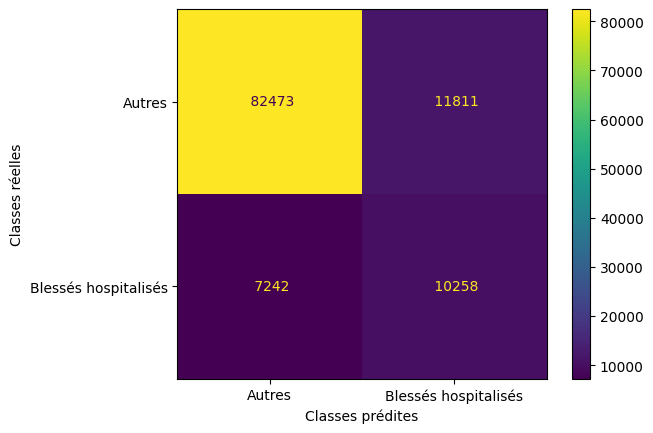

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y__test_pred)
disp = ConfusionMatrixDisplay.from_estimator(
        rf_bl_hosp_model,
        X_test_rf,
        y_test,
        display_labels=['Autres','Blessés hospitalisés'],
        values_format=' '
    )
disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
plt.grid(False)
plt.savefig('../../../data/img/'+ 'rf_binaire_blhospvsautres_confusion_matrix' + '.png')

### Feature importance

In [131]:
importances_best_model = pd.DataFrame({'feature':X_train_rf.columns,'importance':np.round(best_model.feature_importances_,3)})
importances_best_model = importances_best_model.sort_values('importance',ascending=False).set_index('feature')
importances_best_model.head(38)

,importance
feature,
lat,0.104
eq_ceinture,0.097
long,0.078
col,0.070
agg,0.064
obsm,0.055
age_usager,0.051
catv,0.051
catr,0.049


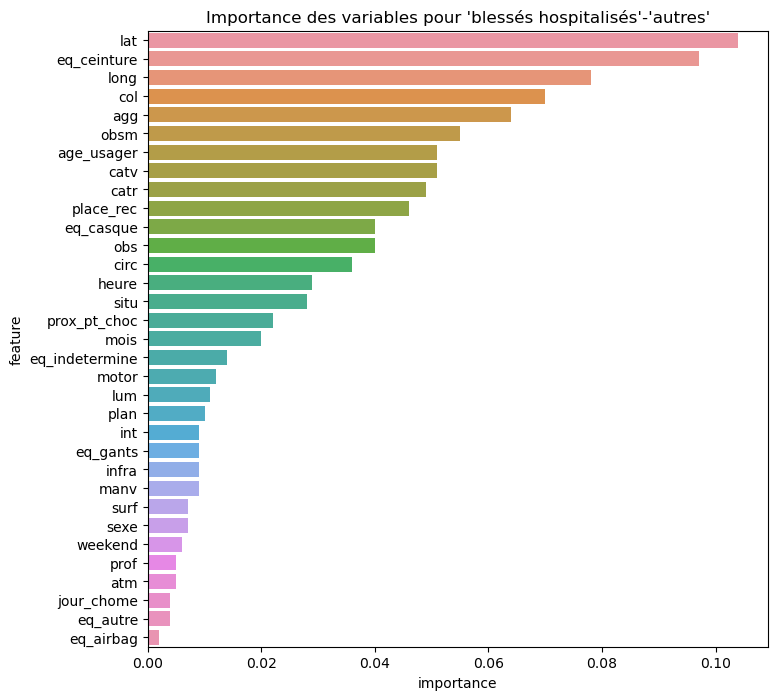

In [133]:
plt.figure(figsize = (8, 8))
sns.barplot(y = importances_best_model.index, x = importances_best_model['importance'])
plt.title("Importance des variables pour 'blessés hospitalisés'-'autres'")
plt.show()

### Interprétation avec SHAP

In [13]:
import shap

explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test_rf)

print('Expected Value:', explainer.expected_value)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Expected Value: [0.64231829 0.35768171]


In [14]:
print(shap_values.shape)
print(type(shap_values))
print(shap_values[0].shape)
print(shap_values[1].shape)

(111784, 33, 2)
<class 'numpy.ndarray'>
(33, 2)
(33, 2)


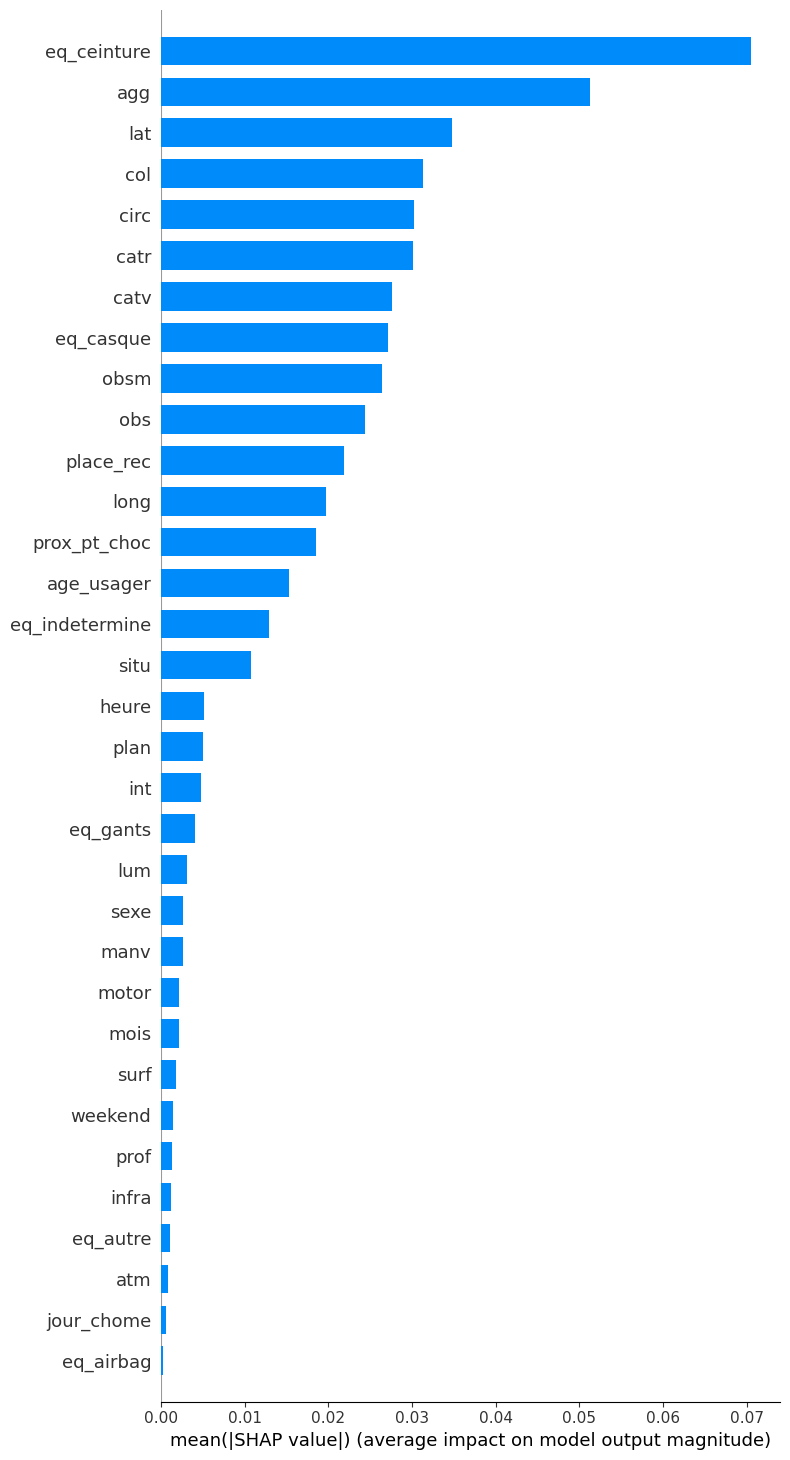

In [15]:
# Pour la classe 'autres'
shap.summary_plot(shap_values[:, :, 0], X_test_rf, plot_type="bar", max_display = len(X_test_rf))

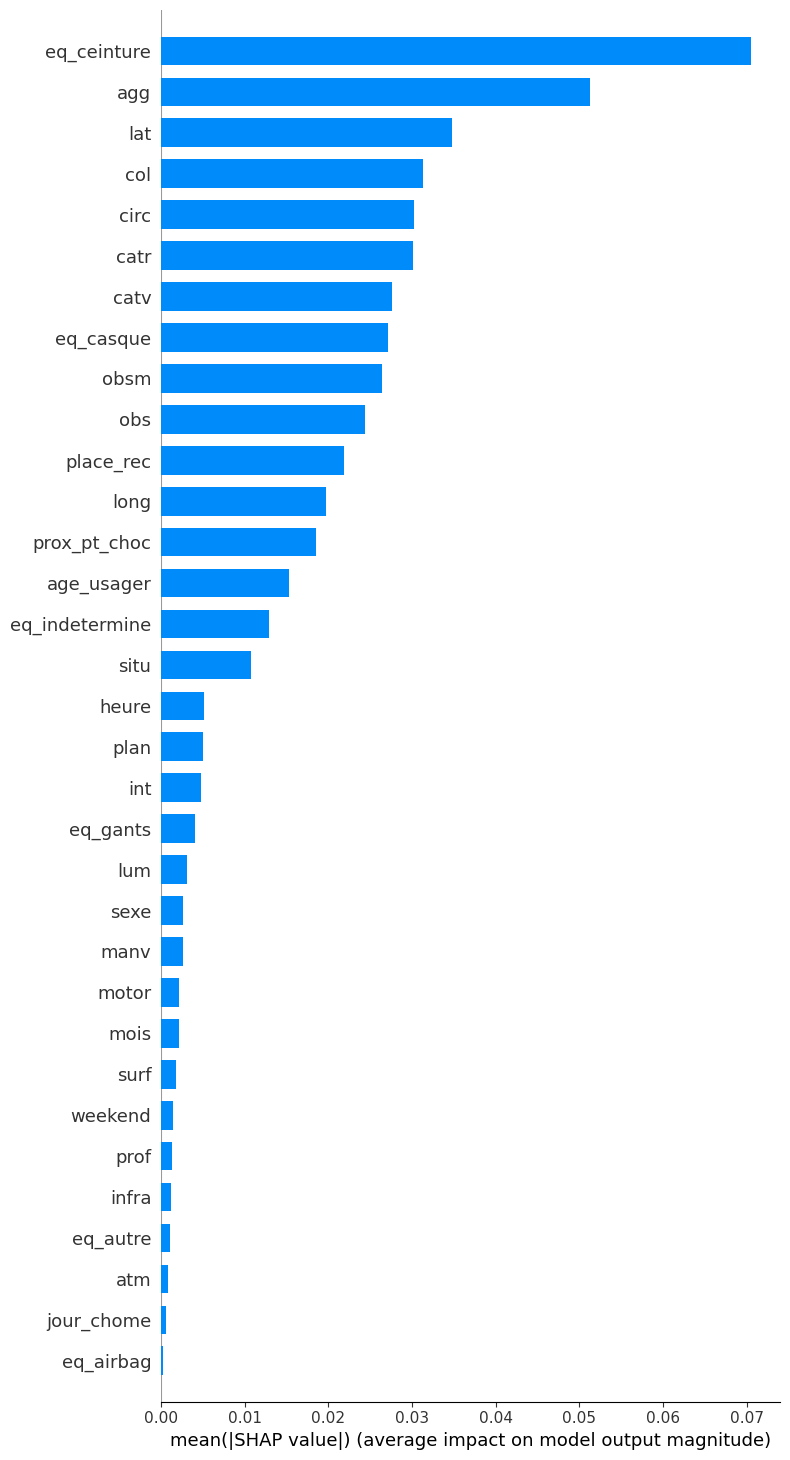

In [16]:
# Pour la classe 'blessés hospitalisés'
shap.summary_plot(shap_values[:, :, 1], X_test_rf, plot_type="bar", max_display = len(X_test_rf))

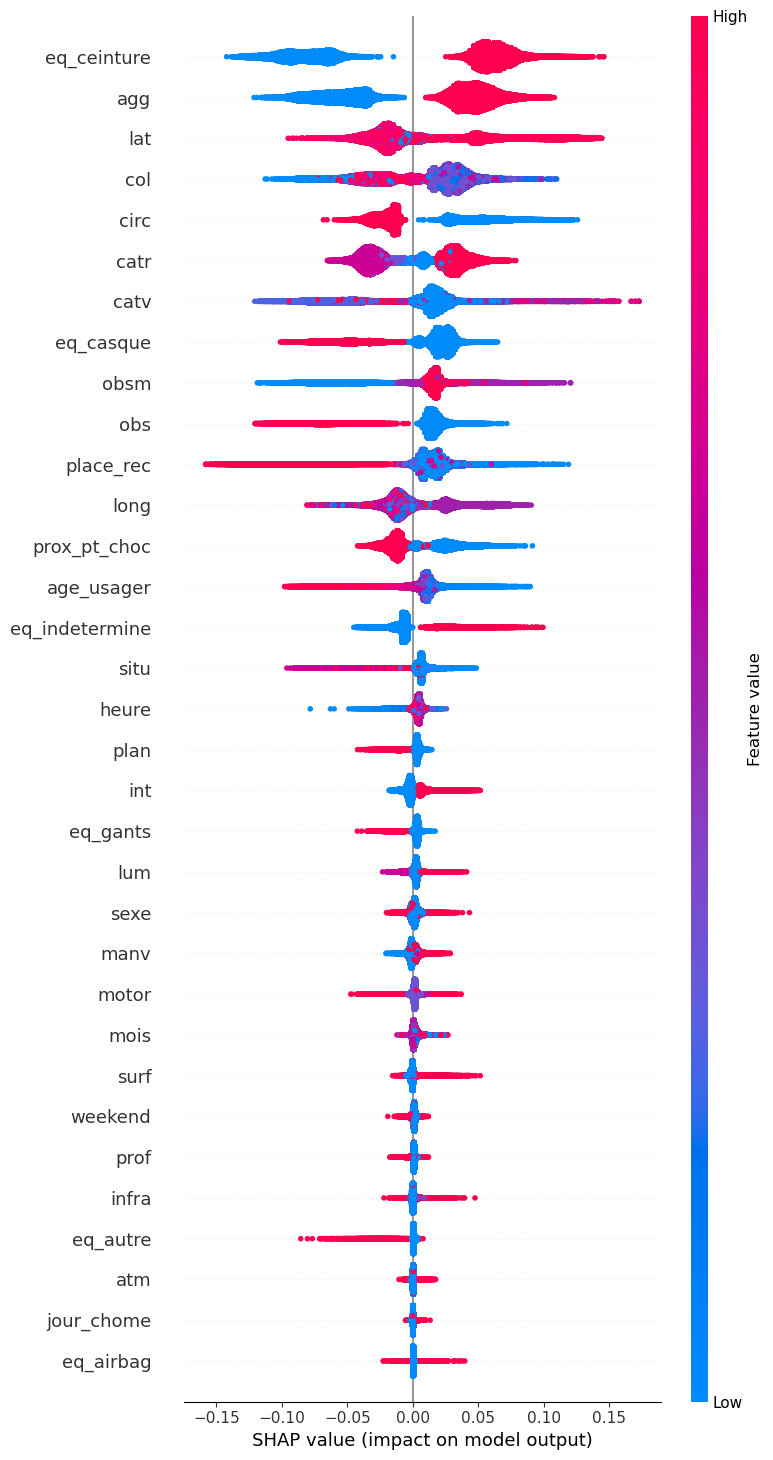

In [17]:
# Pour les 'autres'
shap.summary_plot(shap_values[:, :, 0], X_test_rf, max_display = len(X_test_rf))

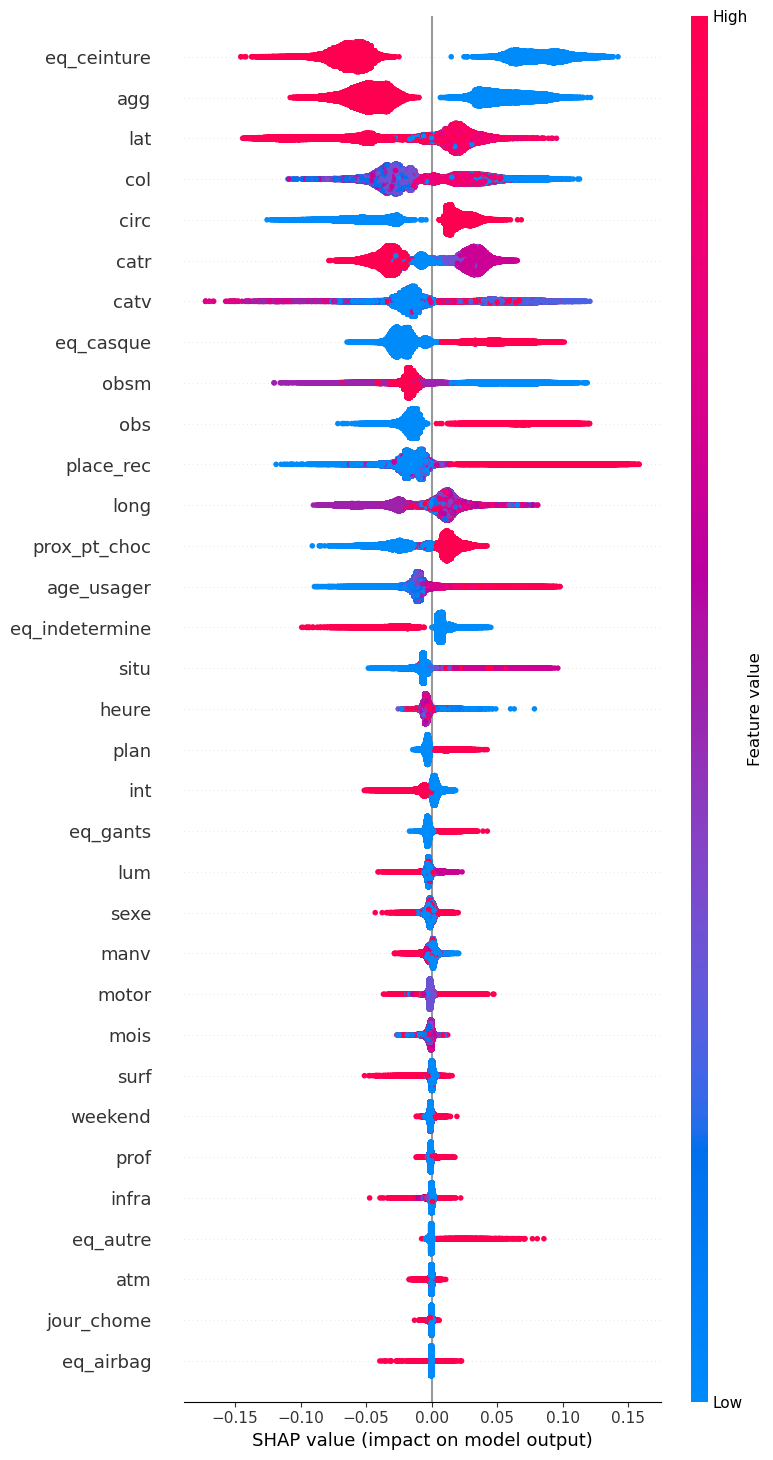

In [18]:
# Pour les 'blessés hospitalisés'
shap.summary_plot(shap_values[:, :, 1], X_test_rf, max_display = len(X_test_rf))

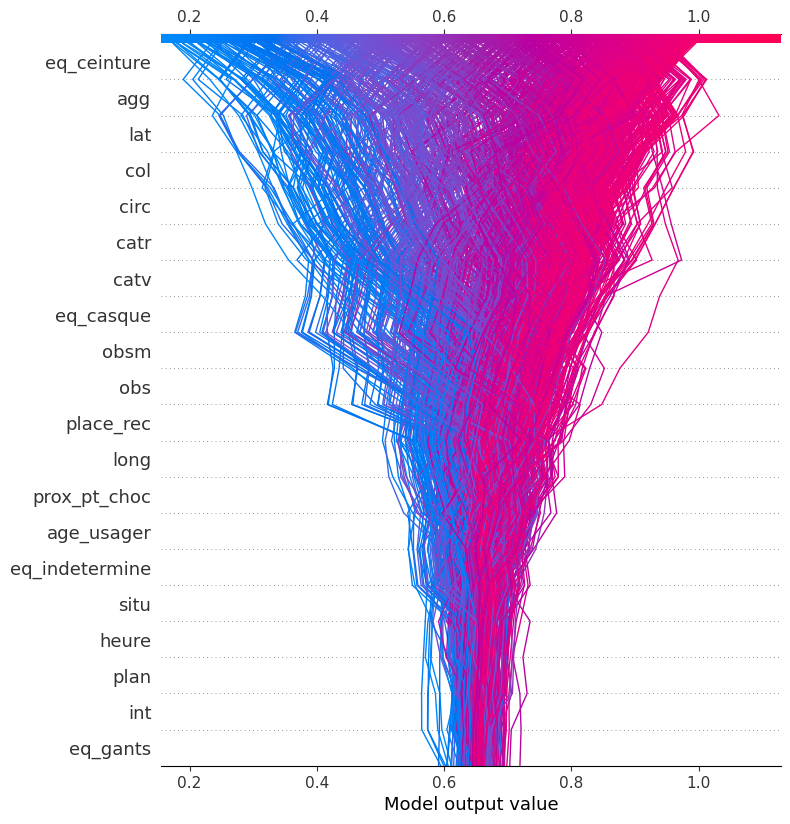

In [140]:
# détermination des variables qui contribuent au label '0'
shap.decision_plot(explainer.expected_value[0], shap_values[0:1000, :, 0], X_test_rf.columns)

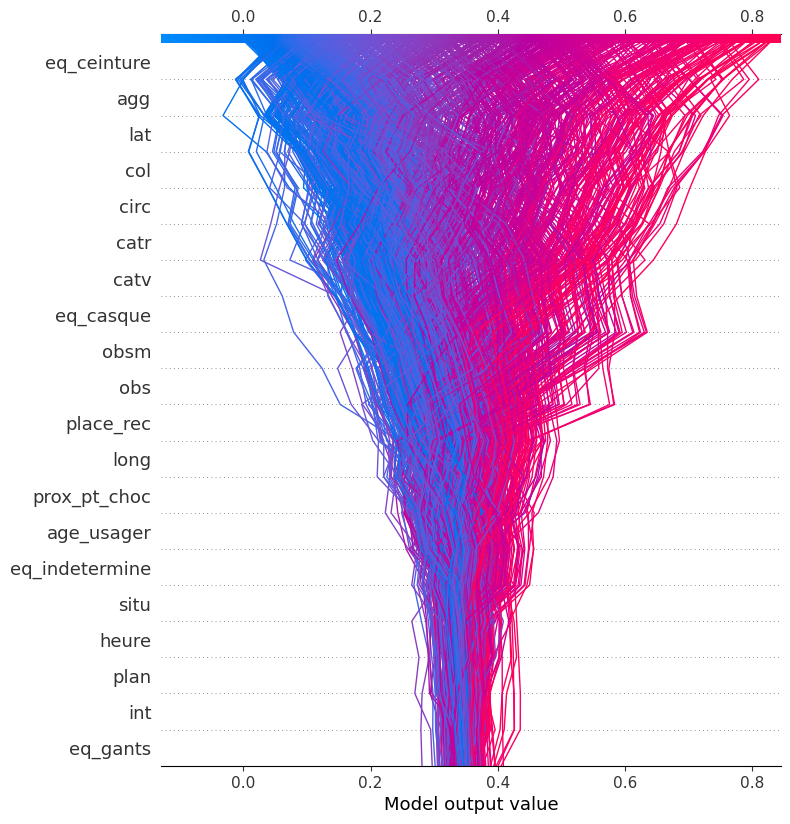

In [141]:
# détermination des variables qui contribuent au label '1'
shap.decision_plot(explainer.expected_value[1], shap_values[0:1000, :, 1], X_test_rf.columns)

# Améliorations du modèle avec monotonic_cts

In [32]:
weight = pd.DataFrame(X_test_rf.columns, columns = ['features'])
weight['weight'] = 0

In [228]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[i]= mono
        
        best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = {0: 1, 1: 3}, 
                                    criterion = 'entropy', 
                                    max_depth = 14, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
        y_train_pred = best_model.predict(X_train_rf)
        y_test_pred = best_model.predict(X_test_rf)
        
        train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
        test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
        f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
        f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
        index_list.append(i)
        features_list.append(weight.loc[i]['features'])
        weight_list.append(mono)
        train_accuracy_list.append(train_accuray)
        test_accuracy_list.append(test_accuracy)
        f1_score_0_list.append(f1_scores[0])
        f1_score_1_list.append(f1_scores[1])
        f1_macro_list.append(f1_macros)

In [229]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 51.5].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
55,27,int,1,85.30,82.27,89.11,52.21,70.66
50,25,plan,-1,85.34,82.24,89.10,52.20,70.65
5,2,age_usager,1,85.44,83.01,89.70,51.57,70.63
22,11,manv,-1,85.23,82.25,89.11,52.15,70.63
63,31,eq_autre,1,85.49,82.39,89.21,52.05,70.63
42,21,jour_chome,-1,85.37,82.30,89.15,52.11,70.63
38,19,weekend,-1,85.34,82.27,89.12,52.13,70.63
33,16,infra,1,85.41,82.35,89.18,52.08,70.63
47,23,surf,1,85.50,82.39,89.22,52.03,70.62
40,20,eq_casque,-1,85.38,82.29,89.13,52.11,70.62


In [217]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []
j = 27

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[j] = 1
        if i != j :
            weight["weight"].values[i]= mono
        
            best_model = RandomForestClassifier(bootstrap = True, 
                                                class_weight = {0: 1, 1: 3}, 
                                                criterion = 'entropy', 
                                                max_depth = 14, 
                                                min_samples_leaf = 1, 
                                                min_samples_split = 2, 
                                                n_estimators = 100, 
                                                n_jobs = -1, 
                                                random_state = 42,
                                                monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
            y_train_pred = best_model.predict(X_train_rf)
            y_test_pred = best_model.predict(X_test_rf)
        
            train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
            test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
            f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
            f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
            index_list.append(i)
            features_list.append(weight.loc[i]['features'])
            weight_list.append(mono)
            train_accuracy_list.append(train_accuray)
            test_accuracy_list.append(test_accuracy)
            f1_score_0_list.append(f1_scores[0])
            f1_score_1_list.append(f1_scores[1])
            f1_macro_list.append(f1_macros)

In [219]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 51.5].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
42,21,jour_chome,-1,85.31,82.34,89.16,52.32,70.74
21,10,lum,1,85.21,82.32,89.15,52.20,70.68
36,18,circ,-1,85.15,82.23,89.08,52.22,70.65
33,16,infra,1,85.33,82.40,89.22,52.03,70.62
32,16,infra,-1,85.15,82.17,89.04,52.19,70.62
47,23,surf,1,85.26,82.25,89.11,52.11,70.61
9,4,mois,1,85.07,82.20,89.07,52.13,70.60
55,28,atm,1,85.32,82.28,89.13,52.07,70.60
34,17,sexe,-1,85.06,82.17,89.04,52.16,70.60
29,14,situ,1,85.23,82.74,89.49,51.71,70.60


In [220]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []
j = 27
k = 21

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[j] = 1
        weight["weight"].values[k] = -1
        if (i != j) & (i != k) :
            weight["weight"].values[i]= mono
        
            best_model = RandomForestClassifier(bootstrap = True, 
                                                class_weight = {0: 1, 1: 3}, 
                                                criterion = 'entropy', 
                                                max_depth = 14, 
                                                min_samples_leaf = 1, 
                                                min_samples_split = 2, 
                                                n_estimators = 100, 
                                                n_jobs = -1, 
                                                random_state = 42,
                                                monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
            y_train_pred = best_model.predict(X_train_rf)
            y_test_pred = best_model.predict(X_test_rf)
        
            train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
            test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
            f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
            f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
            index_list.append(i)
            features_list.append(weight.loc[i]['features'])
            weight_list.append(mono)
            train_accuracy_list.append(train_accuray)
            test_accuracy_list.append(test_accuracy)
            f1_score_0_list.append(f1_scores[0])
            f1_score_1_list.append(f1_scores[1])
            f1_macro_list.append(f1_macros)

In [221]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 51.5].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
49,25,plan,1,85.60,82.96,89.65,51.85,70.75
61,32,eq_airbag,1,85.34,82.41,89.22,52.23,70.73
31,15,motor,1,85.44,82.56,89.34,52.10,70.72
53,28,atm,1,85.28,82.38,89.20,52.17,70.68
47,24,prof,1,85.39,82.41,89.23,52.08,70.65
46,24,prof,-1,85.17,82.22,89.08,52.23,70.65
6,3,heure,-1,85.18,82.39,89.21,52.04,70.62
36,18,circ,-1,85.17,82.22,89.08,52.16,70.62
29,14,situ,1,85.25,82.75,89.50,51.71,70.61
21,10,lum,1,85.13,82.24,89.10,52.11,70.61


In [225]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []
j = 27
k = 21
l = 25

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[j] = 1
        weight["weight"].values[k] = -1
        weight["weight"].values[l] = 1
        if (i != j) & (i != k) & (i != l):
            weight["weight"].values[i]= mono
        
            best_model = RandomForestClassifier(bootstrap = True, 
                                                class_weight = {0: 1, 1: 3}, 
                                                criterion = 'entropy', 
                                                max_depth = 14, 
                                                min_samples_leaf = 1, 
                                                min_samples_split = 2, 
                                                n_estimators = 100, 
                                                n_jobs = -1, 
                                                random_state = 42,
                                                monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
            y_train_pred = best_model.predict(X_train_rf)
            y_test_pred = best_model.predict(X_test_rf)
        
            train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
            test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
            f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
            f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
            index_list.append(i)
            features_list.append(weight.loc[i]['features'])
            weight_list.append(mono)
            train_accuracy_list.append(train_accuray)
            test_accuracy_list.append(test_accuracy)
            f1_score_0_list.append(f1_scores[0])
            f1_score_1_list.append(f1_scores[1])
            f1_macro_list.append(f1_macros)

In [226]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 51.5].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
47,24,prof,1,85.61,82.94,89.64,51.62,70.63
54,30,eq_gants,-1,85.44,82.75,89.50,51.74,70.62
46,24,prof,-1,85.46,82.75,89.50,51.74,70.62
44,23,surf,-1,85.26,82.62,89.40,51.83,70.61
39,19,weekend,1,85.42,82.77,89.51,51.71,70.61
57,31,eq_autre,1,85.59,82.89,89.61,51.61,70.61
51,28,atm,1,85.57,82.89,89.61,51.61,70.61
58,32,eq_airbag,-1,85.47,82.75,89.50,51.69,70.59
6,3,heure,-1,85.32,82.97,89.67,51.51,70.59
56,31,eq_autre,-1,85.61,82.77,89.52,51.64,70.58


On s'arrête ici pour les ajustement car le f1_macro diminue. On a ajusté les variables 'int', 'jour_chome' et 'plan'

In [33]:
weight['weight'] = 0
weight["weight"].values[27] = 1
weight["weight"].values[21] = -1
weight["weight"].values[25] = 1

best_model = RandomForestClassifier(bootstrap = True, 
                                                class_weight = {0: 1, 1: 3}, 
                                                criterion = 'entropy', 
                                                max_depth = 14, 
                                                min_samples_leaf = 1, 
                                                min_samples_split = 2, 
                                                n_estimators = 100, 
                                                n_jobs = -1, 
                                                random_state = 42,
                                                monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.6 %
Test acuracy :  82.96 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,82473,11811
1,7242,10258



Rapport de classification :
               precision    recall  f1-score   support

           0       0.92      0.87      0.90     94284
           1       0.46      0.59      0.52     17500

    accuracy                           0.83    111784
   macro avg       0.69      0.73      0.71    111784
weighted avg       0.85      0.83      0.84    111784



In [34]:
joblib.dump(best_model, "../../../data/saved_models/RandomForest_2classes_blesseshospitalises_autres.joblib")

['../../../data/saved_models/RandomForest_2classes_blesseshospitalises_autres.joblib']